## 패키지 가져오기

In [1]:
from pykrx import stock
from pykrx import bond
import pandas_datareader.data as web
import FinanceDataReader as fdr

from talib import RSI, BBANDS, MACD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
import time
from tqdm import tqdm

import multiprocessing as mp
from multiprocessing import Pool, Manager

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_cores = mp.cpu_count()
print(f"사용가능한 코어 수: {num_cores}")

사용가능한 코어 수: 8


In [3]:
# 2023년 3월 1일 기준 KOSPI와 KOSDAQ의 종목 수를 파악
start_date, end_date = "2015-02-11", "2023-03-01"
kospi_tickers = stock.get_market_ticker_list(end_date, market='KOSPI')
kosdaq_tickers = stock.get_market_ticker_list(end_date, market='KOSDAQ')
all_tickers = kospi_tickers + kosdaq_tickers

print("KOSPI 종목 수: ", len(kospi_tickers))
print("KOSDAQ 종목 수: ", len(kosdaq_tickers))
print("전체 종목 수: ", len(all_tickers))

KOSPI 종목 수:  943
KOSDAQ 종목 수:  1615
전체 종목 수:  2558


## 전략 수립 및 구현

14일을 기준으로 RSI를 계산하고, RSI가 50을 상향 돌파하면 매수, RSI가 50을 하향돌파 매도하는 전략.  
이 때, 각 자산의 매수 및 매도 비중은 모두 동일 가중 방식을 사용하여 결정. 한편, 리밸런싱 주기는 5일로 설정.  
2015년 3월~2023년 2월에 KOSPI,KOSDAQ에 있는 모든 주식을 대상으로 전략을 실행.  
연간 약 -3%의 수익률을 기록  
다만 수익률과 변동성 모두 이전의 단순한 30 70 전략보다는 좋은 모습을 보여줌  


In [4]:
# 1주(5 영업일)을 기준으로 rebalancing을 실시
rebalance_period = 5
rebalance_date = stock.get_market_ohlcv(start_date, end_date, "005930").index[::rebalance_period]
rebalance_date = pd.to_datetime(rebalance_date, format='%Y-%m-%d')
rebalance_date[:rebalance_period]

DatetimeIndex(['2015-02-11', '2015-02-23', '2015-03-02', '2015-03-09',
               '2015-03-16'],
              dtype='datetime64[ns]', name='날짜', freq=None)

In [5]:
# 쓰이는 모든 티커들을 모음
all_tickers = []
for date in tqdm(rebalance_date):
    kospi_tickers = stock.get_market_ticker_list(date, market='KOSPI')
    kosdaq_tickers = stock.get_market_ticker_list(date, market='KOSDAQ')
    all_tickers += kospi_tickers
    all_tickers += kosdaq_tickers
all_tickers = list(set(all_tickers))
print(f"해당 기간동안의 모든 ticker 개수는 {len(all_tickers)}")

100%|██████████| 397/397 [03:17<00:00,  2.01it/s]

해당 기간동안의 모든 ticker 개수는 2863


In [6]:
def return_price_df(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tqdm(tickers):
        price_df = stock.get_market_ohlcv(start_date, end_date, ticker)['종가'].to_frame(ticker)
        df = pd.concat([df, price_df], axis=1)
    return df

price_df = return_price_df(all_tickers, start_date, end_date)
price_df.to_csv('RSI_price_df.csv')

100%|██████████| 2863/2863 [04:02<00:00, 11.78it/s]


In [7]:
price_df = pd.read_csv('RSI_price_df.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,200780,006920,250930,001685,164060,104830,230980,330730,017250,106240,...,080220,033100,405100,138360,119650,034590,109070,054210,26490K,060570
날짜,,,,,,,,,,,,,,,,,,,,,
2015-02-11,18636,4065,0.0,14450,0.0,22725,0.0,0.0,3013,1397,...,3080,3000,0.0,8129,4476,31950,65412,7511,0.0,6900
2015-02-12,18026,4040,0.0,14400,0.0,23600,0.0,0.0,3179,1370,...,3285,2970,0.0,7911,4476,31800,63756,7674,0.0,6700
2015-02-13,18790,4000,0.0,14450,0.0,23925,0.0,0.0,3093,1352,...,3430,2925,0.0,7644,4392,31650,65412,6983,0.0,7300
2015-02-16,18255,4020,0.0,14400,0.0,23925,0.0,0.0,3152,1361,...,3420,2935,0.0,7677,4384,31750,69000,6772,0.0,7290
2015-02-17,18331,3990,0.0,14250,0.0,24100,0.0,0.0,2900,1348,...,3370,2960,0.0,7761,4504,32000,66792,6542,0.0,6920


In [8]:
# RSI 계산
# timeperiod=14를 사용
rsi = price_df.copy()
for col in price_df.columns:
    rsi[col] = RSI(price_df[col], timeperiod=14)
rsi = rsi.fillna(0)

In [9]:
def calculate_weights(rsi, long=50, short=50):
    signal = rsi.copy()
    for i in tqdm(range(len(rsi.columns))):
        for j in range(len(rsi.index)-1):
            rsi1, rsi2 = rsi.iloc[j,i], rsi.iloc[j+1,i]
            if (rsi1 < long) & (rsi2 >= long):
                signal.iloc[j+1, i] = 1
            elif (rsi1 > short) & (rsi2 <= short):
                signal.iloc[j+1, i] = -1
            else:
                signal.iloc[j+1, i] = 0
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        short_signal = (arr == -1).astype(int)
        long_cnt = np.sum(long_signal)
        short_cnt = np.sum(short_signal)
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        if short_cnt > 0:
            short_signal = -1 * short_signal / short_cnt
        return long_signal + short_signal
        
    signal = signal.apply(calculate_weights_from_signal, axis=1)
    signal.index = pd.to_datetime(signal.index, format='%Y-%m-%d')
    return signal

weights = calculate_weights(rsi)
weights.to_csv("RSI_strategy2.csv")

100%|██████████| 2863/2863 [11:53<00:00,  4.01it/s]


In [10]:
# rebalance를 반영해서 weight를 수정
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [11]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,200780,006920,250930,001685,164060,104830,230980,330730,017250,106240,...,080220,033100,405100,138360,119650,034590,109070,054210,26490K,060570
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-22,-0.003783,-0.004843,-0.007640,0.008286,0.012469,0.012153,-0.026923,0.011561,-0.008721,0.021505,...,0.005203,0.012999,-0.021522,-0.002177,-0.007238,-0.001848,0.0,0.014881,-0.015886,0.030137
2023-02-23,-0.021519,-0.026764,-0.023097,-0.001264,-0.019704,0.039451,0.040843,-0.007619,-0.004399,-0.019298,...,0.031056,-0.003666,0.030636,0.016727,-0.006169,-0.009259,0.0,-0.012463,0.002549,0.014628
2023-02-24,-0.003881,0.010000,-0.021016,-0.010759,-0.025126,-0.018152,-0.025316,-0.024952,-0.036082,-0.025045,...,-0.037149,0.039558,-0.025915,-0.069385,0.000000,0.009346,0.0,0.001485,0.000000,-0.030144
2023-02-27,0.000000,0.013614,0.001789,0.007678,0.014175,-0.005042,0.005195,0.007874,0.042017,-0.007339,...,-0.005214,-0.005310,0.002347,-0.017679,0.033296,0.001852,0.0,0.032617,-0.014407,0.025676
2023-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [12]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,0.000000
...,...
2023-02-21,0.004336
2023-02-22,-0.003517
2023-02-23,-0.008458


In [13]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,0.000000
...,...
2023-02-21,-0.199153
2023-02-22,-0.201969
2023-02-23,-0.208719


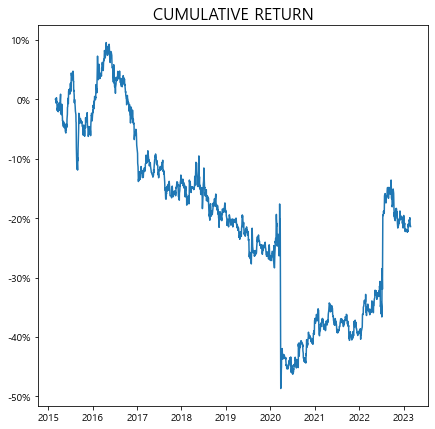

In [14]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## 자세한 결과 분석

In [15]:
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

Text(0.5, 1.0, 'Rolling Sharpe Ratio (3 Months)')

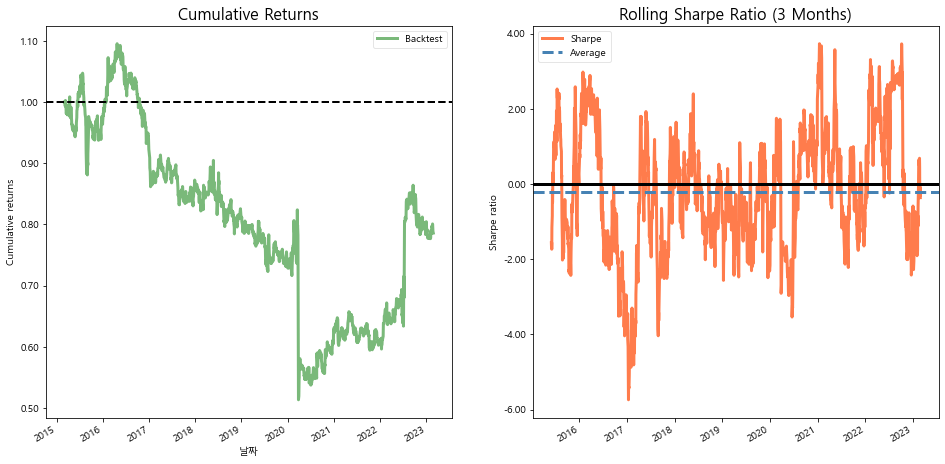

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_rolling_returns(daily_return['daily_return'],
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return['daily_return'], ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns', fontsize=16)
axes[1].set_title('Rolling Sharpe Ratio (3 Months)', fontsize=16)

Start date,2015-03-02
End date,2023-02-27
Total months,93
,Backtest
Annual return,-3.034%
Cumulative returns,-21.407%
Annual volatility,15.958%
Sharpe ratio,-0.11
Calmar ratio,-0.06
Stability,0.62
Max drawdown,-53.132%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,53.13,2016-04-22,2020-03-27,NaT,NaN
1,15.88,2015-07-24,2015-08-31,2016-02-11,145
2,6.47,2015-04-13,2015-05-26,2015-06-18,49
3,3.69,2016-02-11,2016-02-18,2016-04-08,42
4,2.35,2015-03-10,2015-03-25,2015-04-13,25


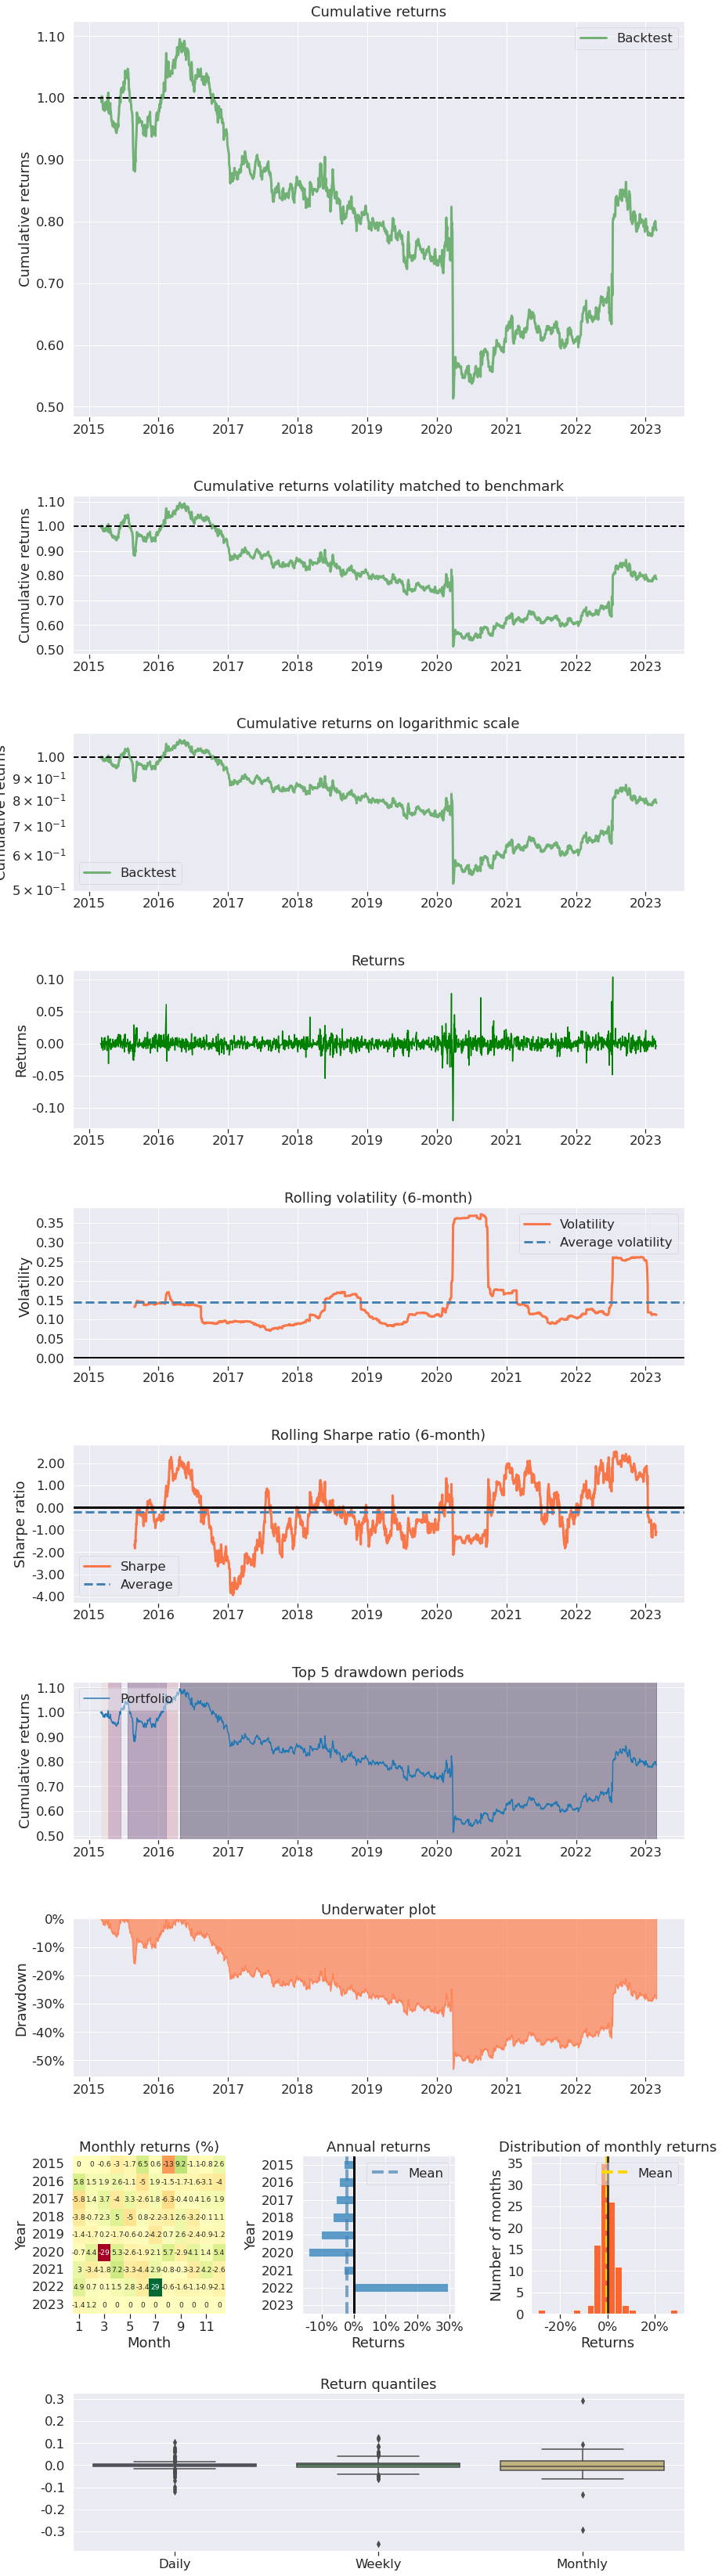

In [17]:
pf.create_returns_tear_sheet(daily_return['daily_return'])

## 전략수정(매일 리밸런싱 실시)

위의 RSI 기반 전략의 성과를 개선하기 위해 리밸런싱 기간을 daily로 조정  
2%정도의 연간 수익률을 기록  
최근에 좋은 수익률을 보여주었다는 점은 인상적

In [18]:
rebalance_date = stock.get_market_ohlcv(start_date, end_date, "005930").index
rebalance_date = pd.to_datetime(rebalance_date, format='%Y-%m-%d')
rebalance_date

DatetimeIndex(['2015-02-11', '2015-02-12', '2015-02-13', '2015-02-16',
               '2015-02-17', '2015-02-23', '2015-02-24', '2015-02-25',
               '2015-02-26', '2015-02-27',
               ...
               '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-20',
               '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='날짜', length=1981, freq=None)

In [19]:
weights = pd.read_csv("RSI_strategy2.csv", index_col=0)
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

# rebalance를 반영해서 weight를 수정
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,200780,006920,250930,001685,164060,104830,230980,330730,017250,106240,...,080220,033100,405100,138360,119650,034590,109070,054210,26490K,060570
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-22,-0.003783,-0.004843,-0.007640,0.008286,0.012469,0.012153,-0.026923,0.011561,-0.008721,0.021505,...,0.005203,0.012999,-0.021522,-0.002177,-0.007238,-0.001848,0.0,0.014881,-0.015886,0.030137
2023-02-23,-0.021519,-0.026764,-0.023097,-0.001264,-0.019704,0.039451,0.040843,-0.007619,-0.004399,-0.019298,...,0.031056,-0.003666,0.030636,0.016727,-0.006169,-0.009259,0.0,-0.012463,0.002549,0.014628
2023-02-24,-0.003881,0.010000,-0.021016,-0.010759,-0.025126,-0.018152,-0.025316,-0.024952,-0.036082,-0.025045,...,-0.037149,0.039558,-0.025915,-0.069385,0.000000,0.009346,0.0,0.001485,0.000000,-0.030144
2023-02-27,0.000000,0.013614,0.001789,0.007678,0.014175,-0.005042,0.005195,0.007874,0.042017,-0.007339,...,-0.005214,-0.005310,0.002347,-0.017679,0.033296,0.001852,0.0,0.032617,-0.014407,0.025676
2023-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [20]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,-0.001844
...,...
2023-02-21,0.004336
2023-02-22,-0.023018
2023-02-23,0.002029


In [21]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,-0.001844
...,...
2023-02-21,0.247325
2023-02-22,0.218613
2023-02-23,0.221086


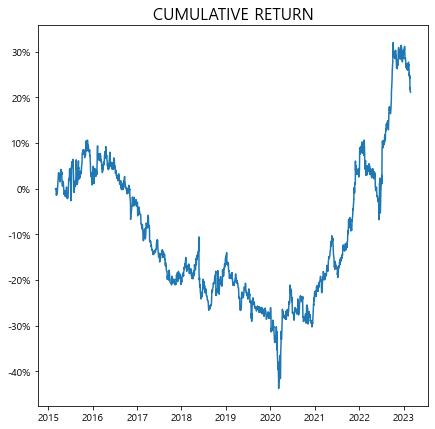

In [22]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

Text(0.5, 1.0, 'Rolling Sharpe Ratio (3 Months)')

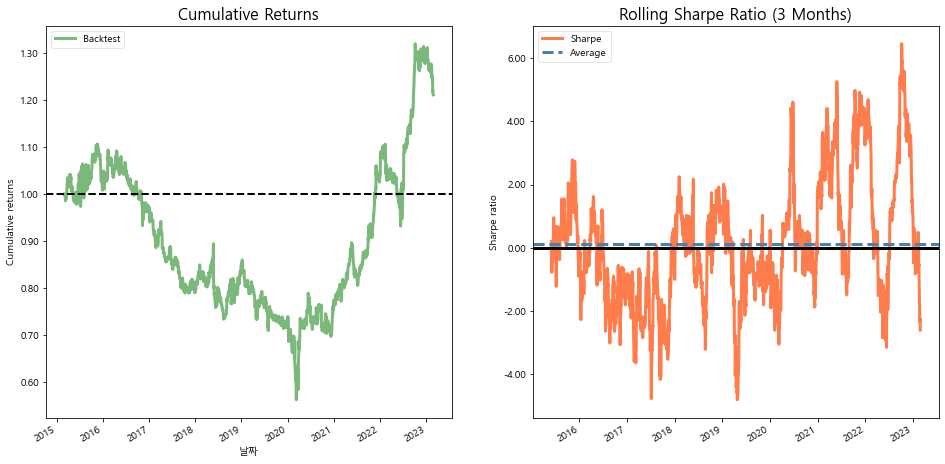

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_rolling_returns(daily_return['daily_return'],
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return['daily_return'], ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns', fontsize=16)
axes[1].set_title('Rolling Sharpe Ratio (3 Months)', fontsize=16)

Start date,2015-03-02
End date,2023-02-27
Total months,93
,Backtest
Annual return,2.482%
Cumulative returns,21.126%
Annual volatility,16.326%
Sharpe ratio,0.23
Calmar ratio,0.05
Stability,0.00
Max drawdown,-49.175%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,49.18,2015-11-20,2020-03-10,2022-02-11,1626
1,15.78,2022-02-11,2022-06-13,2022-07-28,120
2,8.23,2022-10-07,2023-02-27,NaT,NaN
3,6.83,2015-07-23,2015-08-03,2015-10-08,56
4,6.79,2015-07-03,2015-07-08,2015-07-13,7


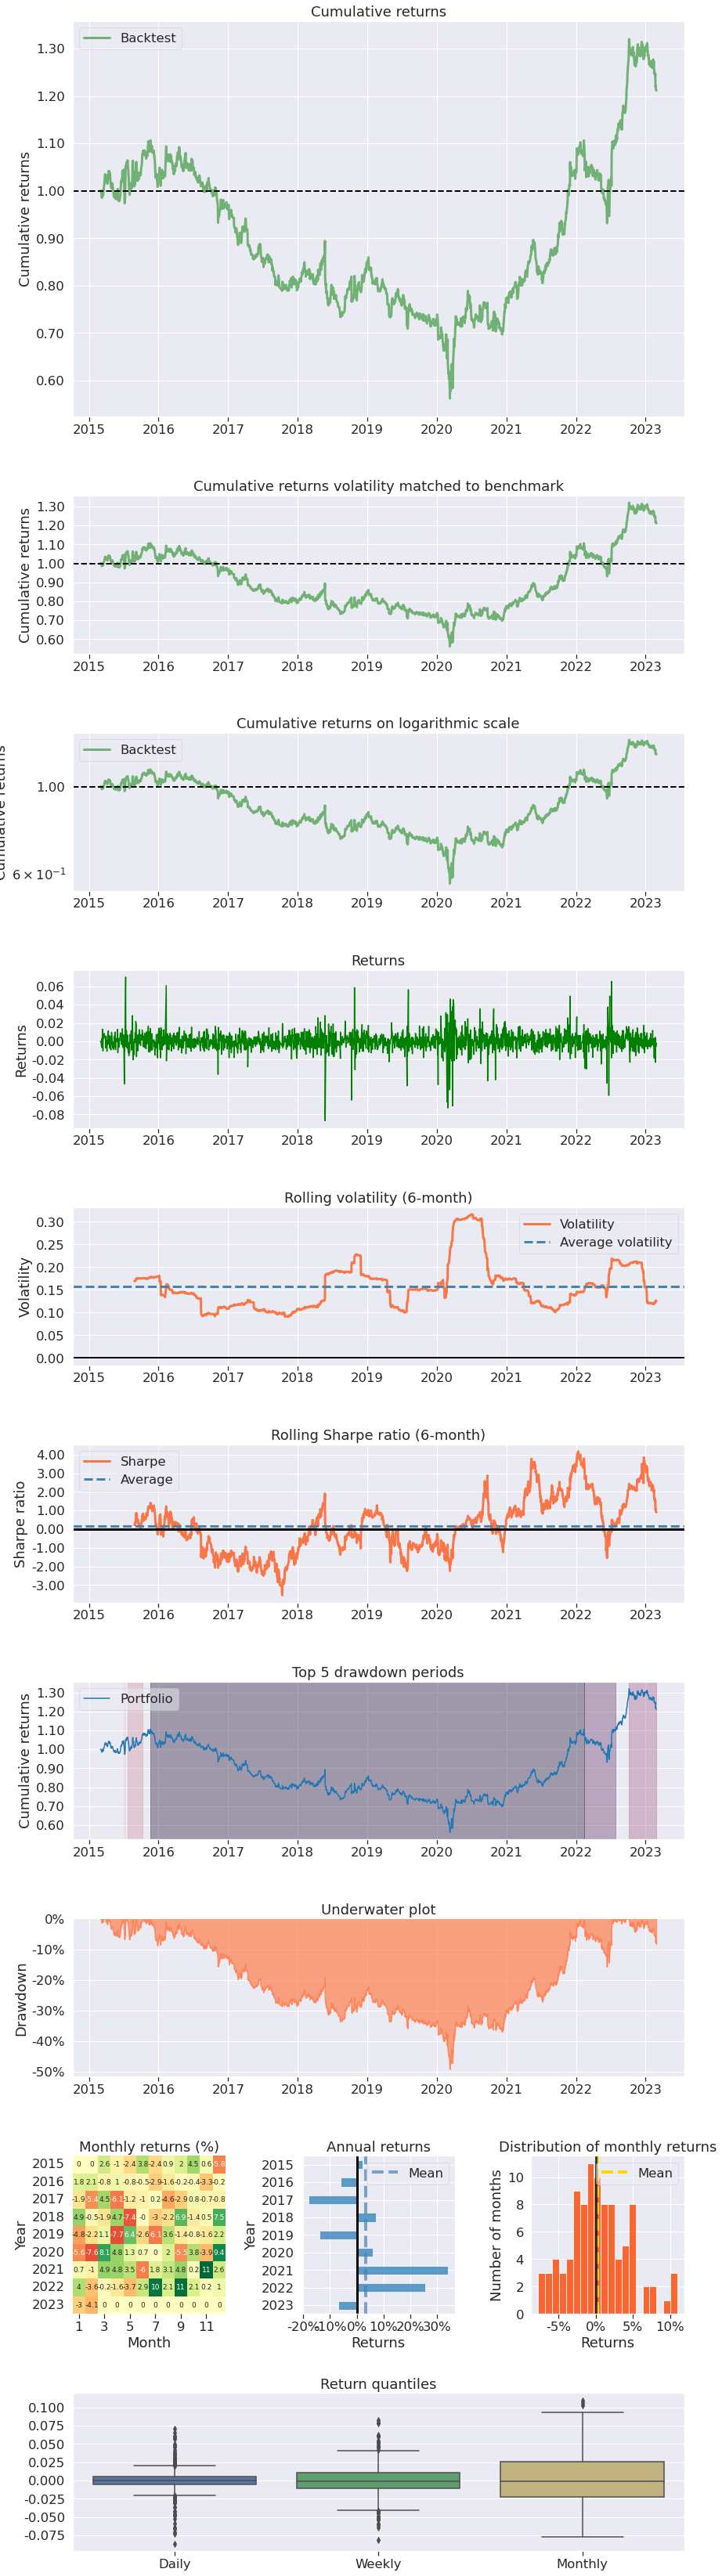

In [24]:
pf.create_returns_tear_sheet(daily_return['daily_return'])